# Vehicle Re-identification using Transformer and Contrastive Learning

In [21]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm

from dataset import VehicleReIDDataset
from vit import ViTEncoder
from loss import TripletLoss

import matplotlib.pyplot as plt

In [2]:
# DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
print(DEVICE)

cpu


### Utility Functions

In [3]:
def get_hard_triplets(embeddings, labels):
    '''
    Selects hard positives and negatives based on Euclidean distances.
    '''
    labels = labels.cpu().numpy()
    pairwise_distances = torch.cdist(embeddings, embeddings)  # Compute pairwise distances

    hard_triplets = []
    for i in range(len(labels)):
        anchor_idx = i
        anchor_label = labels[i]

        # Hard positive: Closest with same label
        positive_indices = np.where(labels == anchor_label)[0]
        positive_indices = positive_indices[positive_indices != i]  # Exclude self
        if len(positive_indices) == 0:
            continue
        positive_idx = positive_indices[torch.argmin(pairwise_distances[i, positive_indices])]

        # Hard negative: Furthest with different label
        negative_indices = np.where(labels != anchor_label)[0]
        negative_idx = negative_indices[torch.argmax(pairwise_distances[i, negative_indices])]

        hard_triplets.append((anchor_idx, positive_idx, negative_idx))

    return hard_triplets

In [4]:
def extract_embeddings(model, dataloader, device):
    '''
    Extracts embeddings for images in the dataset.
    '''
    model.eval()
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            embeddings = model(images)
            all_embeddings.append(embeddings.cpu())
            all_labels.extend(labels.numpy())

    return torch.cat(all_embeddings), np.array(all_labels)

def retrieve_top_k(embedding, dataset_embeddings, dataset_labels, k=5):
    '''
    Retrieve top-k similar images using Euclidean distance.
    '''
    distances = torch.cdist(embedding.unsqueeze(0), dataset_embeddings)
    top_k_indices = torch.argsort(distances, dim=1)[0][:k]
    return dataset_labels[top_k_indices]

### Training

In [4]:
def train(model, dataloader, optimizer, loss_fn, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            # Extract embeddings
            embeddings = model(images)

            # Hard triplet selection
            triplets = get_hard_triplets(embeddings, labels)
            if len(triplets) == 0:
                continue

            anchor, positive, negative = zip(*triplets)
            anchor = torch.stack([embeddings[i] for i in anchor])
            positive = torch.stack([embeddings[i] for i in positive])
            negative = torch.stack([embeddings[i] for i in negative])

            # Compute loss
            loss = loss_fn(anchor, positive, negative)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f'Epoch {epoch+1:3}/{epochs:3} | Loss: {epoch_loss/len(dataloader):.4f}')

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize dataset and dataloader
dataset = VehicleReIDDataset(root_dir='data/prepared_VeRi_CARLA_dataset/test', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

model = ViTEncoder(
    embed_dim=256,
    depth=4,
    n_heads=8,
    out_dim=512,
) 
model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = TripletLoss(margin=0.3)

In [7]:
# Train model
train(model, dataloader, optimizer, loss_fn, DEVICE, epochs=10)

100%|██████████| 2888/2888 [05:14<00:00,  9.18it/s]


Epoch   1/ 10 | Loss: 0.0063


100%|██████████| 2888/2888 [05:10<00:00,  9.30it/s]


Epoch   2/ 10 | Loss: 0.0057


100%|██████████| 2888/2888 [05:09<00:00,  9.33it/s]


Epoch   3/ 10 | Loss: 0.0047


100%|██████████| 2888/2888 [05:13<00:00,  9.20it/s]


Epoch   4/ 10 | Loss: 0.0051


100%|██████████| 2888/2888 [05:11<00:00,  9.27it/s]


Epoch   5/ 10 | Loss: 0.0044


100%|██████████| 2888/2888 [05:28<00:00,  8.80it/s]


Epoch   6/ 10 | Loss: 0.0038


100%|██████████| 2888/2888 [05:14<00:00,  9.17it/s]


Epoch   7/ 10 | Loss: 0.0035


100%|██████████| 2888/2888 [05:22<00:00,  8.94it/s]


Epoch   8/ 10 | Loss: 0.0042


100%|██████████| 2888/2888 [05:20<00:00,  9.02it/s]


Epoch   9/ 10 | Loss: 0.0025


100%|██████████| 2888/2888 [05:24<00:00,  8.90it/s]


Epoch  10/ 10 | Loss: 0.0042


In [12]:
# Save model
torch.save(model.state_dict(), 'trained_models/model.pth')

### Inference

In [8]:
model = ViTEncoder(
    embed_dim=256,
    depth=4,
    n_heads=8,
    out_dim=512,
)
model.load_state_dict(torch.load('trained_models/model.pth'))
model.to(DEVICE)

model.eval()

ViTEncoder(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-3): 4 x Block(
      (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
  (projection_head): Sequential(
    (0): Linear(in_features=256,

Anchor-Positive distance: 1.758861780166626
Anchor-Negative distance: 1.8804292678833008
Anchor-Postive distance < Anchor-Negative distance: True


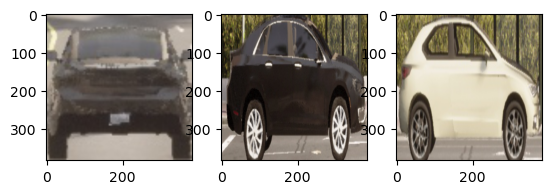

In [61]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize dataset and dataloader
dataset = VehicleReIDDataset(root_dir='data/prepared_VeRi_CARLA_dataset/test', transform=transform)
dataloader = DataLoader(dataset, batch_size=250, shuffle=True)

# select a batch of images and labels
images, labels = next(iter(dataloader))
images = images.to(DEVICE)

# Select three images as (anchor, positive, negative)
anchor_img = images[0]
anchor_label = labels[0]

positive_indices = np.where(labels == anchor_label)[0]
positive_img = images[positive_indices[1]]

negative_indices = np.where(labels != anchor_label)[0]
negative_img = images[negative_indices[0]]

anchor = anchor_img.unsqueeze(0)
positive = positive_img.unsqueeze(0)
negative = negative_img.unsqueeze(0)

# Extract embeddings
anchor_embedding = model(anchor)
positive_embedding = model(positive)
negative_embedding = model(negative)

# Compute pairwise distances
anchor_positive_distance = torch.cdist(anchor_embedding, positive_embedding)
anchor_negative_distance = torch.cdist(anchor_embedding, negative_embedding)

print(f'Anchor-Positive distance: {anchor_positive_distance.item()}')
print(f'Anchor-Negative distance: {anchor_negative_distance.item()}')

print(f'Anchor-Postive distance < Anchor-Negative distance: {(anchor_positive_distance < anchor_negative_distance).item()}')

# unnormlize the images
anchor_img = anchor_img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
positive_img = positive_img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
negative_img = negative_img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

# visualize the images
fig, ax = plt.subplots(1, 3)
ax[0].imshow(anchor_img.permute(1, 2, 0).cpu().numpy())
ax[1].imshow(positive_img.permute(1, 2, 0).cpu().numpy())
ax[2].imshow(negative_img.permute(1, 2, 0).cpu().numpy())
plt.show()